In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from numba import jit

In [2]:
tidal_shear054 = np.load('/vol/calvin/data/adave/Internship/tidal_shear054.npy')

In [3]:
tidal_shear054.shape

(512, 512, 512, 3, 3)

In [4]:
# # Reshape tidal_shear to make it a 2D array with shape (512*512*512, 3, 3)
# tidal_shear_2d = tidal_shear.reshape(-1, 3, 3)

# # Initialize arrays to store eigenvalues and eigenvectors
# eigenvalues = np.zeros((512*512*512, 3))
# eigenvectors = np.zeros((512*512*512, 3, 3))

# # Calculate eigenvalues and eigenvectors using vectorized operations
# for idx in tqdm(range(512*512*512)):
#     eigenvalues[idx], eigenvectors[idx] = np.linalg.eig(tidal_shear_2d[idx])

# # Reshape eigenvalues and eigenvectors back to the original shape
# eigenvalues = eigenvalues.reshape(512, 512, 512, 3)
# eigenvectors = eigenvectors.reshape(512, 512, 512, 3, 3)


In [66]:
evals1, evects1 = np.linalg.eig(tidal_shear054[0, 0, 1])

In [67]:
evals1

array([-0.72735117,  0.11822688, -0.1159283 ])

In [77]:
evects1

array([[ 0.77686006,  0.57310434,  0.26084452],
       [ 0.17442092, -0.59390314,  0.78540207],
       [-0.60503371,  0.56465076,  0.56134101]])

In [69]:
sort_indices = np.argsort(evals1)[::-1]

In [70]:
evals = evals1[sort_indices]
evects = evects1[sort_indices]

In [74]:
evals

array([ 0.11822688, -0.1159283 , -0.72735117])

In [78]:
evects[-1]

array([0.77686006, 0.57310434, 0.26084452])

In [56]:
# Define the JIT-compiled function
@jit(nopython=True)
def calculate_eigenvalues_and_vectors(tidal_shear054):
    eigenvalues = np.zeros((512, 512, 512, 3))
    eigenvectors = np.zeros((512, 512, 512, 3, 3))

    for i in range(512):
        for j in range(512):
            for k in range(512):
                eigenvalues[i, j, k], eigenvectors[i, j, k] = np.linalg.eig(tidal_shear054[i, j, k])
                
                # Sort the eigenvalues and corresponding eigenvectors in descending order
                sorted_indices = np.argsort(eigenvalues[i, j, k])[::-1]
                eigenvalues[i, j, k] = eigenvalues[i, j, k][sorted_indices]
                eigenvectors[i, j, k] = eigenvectors[i, j, k][sorted_indices]

    return eigenvalues, eigenvectors

import time
s1 = time.perf_counter()
# Call the JIT-compiled function
eigenvalues, eigenvectors = calculate_eigenvalues_and_vectors(tidal_shear054)

s2 = time.perf_counter()
print(s2-s1)

492.32090256363153


In [57]:
eigenvalues[0, 0, 1]

array([ 0.11822688, -0.1159283 , -0.72735117])

In [80]:
eigenvectors[0, 0, 1]

array([[ 0.17442092, -0.59390314,  0.78540207],
       [-0.60503371,  0.56465076,  0.56134101],
       [ 0.77686006,  0.57310434,  0.26084452]])

In [6]:
# eigenvalues = np.zeros((512, 512, 512, 3))
# eigenvectors = np.zeros((512, 512, 512, 3, 3))


# for i in tqdm(range(512)):
#     for j in range(512):
#         for k in range(512):
#             eigenvalues[i, j, k], eigenvectors[i, j, k] = np.linalg.eig(tidal_shear054[i, j, k])

In [11]:
import time

s1 = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(x, np.arange(512))
s2 = time.perf_counter()

print(s1-s2)

NameError: name 'x' is not defined

In [10]:
eigenvalues.shape

(512, 512, 512, 3)

In [11]:
eigenvectors.shape

(512, 512, 512, 3, 3)

In [81]:
np.save("/vol/calvin/data/adave/Internship/eignvals_tidalshear054.npy", eigenvalues)

In [82]:
np.save("/vol/calvin/data/adave/Internship/eignvects_tidalshear054.npy", eigenvectors)

In [84]:
eigenvectors[10, 10, 0]

array([[-0.47653563,  0.86793847, -0.13998789],
       [-0.02167062,  0.14758519,  0.98881191],
       [-0.87888803, -0.47423773,  0.05152083]])

In [11]:
def classify_structure(eigenvalues):
    ''' Classifies each voxel as a part of Void, Sheet, Filament, or Node'''
    num_positive = np.sum(eigenvalues > 0)
    num_negative = np.sum(eigenvalues < 0)

    if num_positive == 0:
        return 0 # "Void"
    elif num_positive == 1 and num_negative == 2:
        return 1 # "Sheet"
    elif num_positive == 2 and num_negative == 1:
        return 2 # "Filament"
    elif num_positive == 3:
        return 3 # "Cluster"

In [12]:
classification_matrix = np.zeros((512, 512, 512))

for i in tqdm(range(512)):
    for j in range(512):
        for k in range(512):
            classification_matrix[i, j, k] = classify_structure(eigenvalues[i, j, k])

100%|██████████| 512/512 [37:51<00:00,  4.44s/it]


In [13]:
np.save("/vol/calvin/data/adave/Internship/Classification_matrix054.npy", classification_matrix)

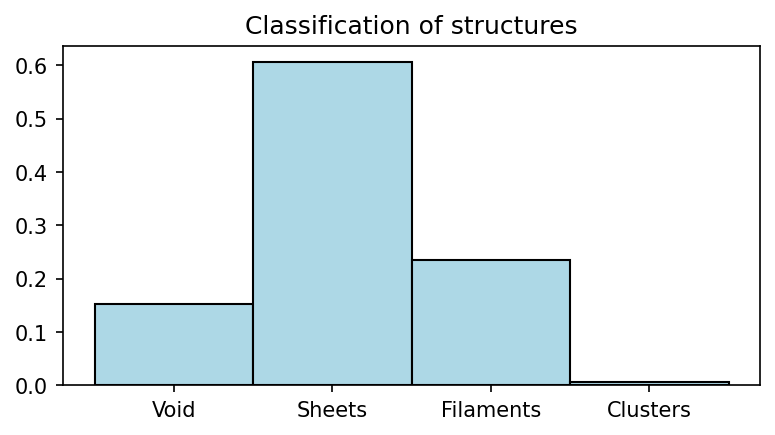

In [14]:
labels = ['Void', 'Sheets', 'Filaments', 'Clusters']

plt.figure(figsize=(6,3), dpi=150)
plt.title('Classification of structures', fontsize = 12)
plt.hist(classification_matrix.flatten(), bins=[-0.5, 0.5, 1.5, 2.5, 3.5], density = True, edgecolor='black', align='mid', color='lightblue')
plt.xticks(range(4), labels)
plt.show()

In [17]:
# Volume fraction of Sheets at small scales
np.sum(classification_matrix == 1) / 512**3

0.5792209729552269

In [18]:
# Volume fraction of Filaments at small scales
np.sum(classification_matrix == 2) / np.prod(classification_matrix.shape)

0.26991845667362213

In [5]:
c = np.load("/vol/calvin/data/adave/Internship/Classification_matrix13.npy")
val = np.load("/vol/calvin/data/adave/Internship/eignvals_tidalshear13.npy")
vecs = np.load("/vol/calvin/data/adave/Internship/eignvects_tidalshear13.npy")

In [6]:
cx = c.reshape(512**3)
vlx = val.reshape(512**3, 3)
vcx = vecs.reshape(512**3, 3, 3)

In [15]:
vlx[34505]

array([ 0.8593695 , -0.32600393, -1.09772064])

In [14]:
cx[34505]

1.0